# Value of Information (VOI) Analysis using NetworkX
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Probabilistic Simulation and Cash Flow

## Introduction
This notebook demonstrates how to build a decision tree to evaluate the economic feasibility of acquiring new subsurface data (e.g., a core sample) before making a drilling decision. We will use `NetworkX` to model the decision flow and `Pandas` to handle prospect parameters.

## Objectives
1.  **Bayesian Inference:** Update geological chance of success ($Pg$) based on hypothetical test results.
2.  **Graph Construction:** Build a decision tree with Decision Nodes, Chance Nodes, and Terminal Nodes.
3.  **Optimization:** Calculate EMV to determine the optimal path for each prospect.

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load Data
df = pd.read_csv('data.csv')
print("Loaded Prospects:")
display(df)

Loaded Prospects:


,prospect_id,prior_prob_oil,payoff_success_mmusd,cost_drill_mmusd,cost_core_mmusd,test_sensitivity,test_specificity
0,Alpha_Zone,0.30,120,40,2.5,0.85,0.80
1,Beta_Block,0.15,200,50,3.0,0.90,0.75
2,Gamma_Deep,0.45,80,30,1.5,0.95,0.90


## 1. Mathematical Helper Functions

We need to define functions to calculate the **Posterior Probabilities** using Bayes' Theorem.

- **Sensitivity:** Probability the test is Positive given Oil is present.
- **Specificity:** Probability the test is Negative given it is Dry.

In [3]:
def calculate_bayes(prior_oil, sensitivity, specificity):
    """
    Calculates posterior probabilities for a diagnostic test.
    Returns:
        P(Oil|Pos), P(Dry|Pos), P(Pos), P(Oil|Neg), P(Dry|Neg), P(Neg)
    """
    prior_dry = 1.0 - prior_oil
    
    # Total Probability of a Positive Signal
    # P(Pos) = P(Pos|Oil)*P(Oil) + P(Pos|Dry)*P(Dry)
    p_pos = (sensitivity * prior_oil) + ((1 - specificity) * prior_dry)
    
    # Total Probability of a Negative Signal
    p_neg = 1.0 - p_pos
    
    # Posterior: P(Oil | Pos)
    p_oil_given_pos = (sensitivity * prior_oil) / p_pos
    
    # Posterior: P(Oil | Neg)
    # P(Neg|Oil) = 1 - Sensitivity
    p_oil_given_neg = ((1 - sensitivity) * prior_oil) / p_neg
    
    return {
        'p_pos': p_pos,
        'p_neg': p_neg,
        'p_oil_pos': p_oil_given_pos,
        'p_dry_pos': 1 - p_oil_given_pos,
        'p_oil_neg': p_oil_given_neg,
        'p_dry_neg': 1 - p_oil_given_neg
    }

## 2. Building the NetworkX Decision Tree

We will create a function that generates a `DiGraph` (Directed Graph) for a single prospect.

**Tree Structure:**
1.  **Root:** Decision (Buy Info vs. Don't Buy).
2.  **Branch A (Don't Buy):** Decision (Drill vs. Drop).
3.  **Branch B (Buy Info):** Chance (Test Positive vs. Negative) -> Decision (Drill vs. Drop).

In [4]:
def build_decision_tree(prospect):
    G = nx.DiGraph()
    
    # Extract params
    prior = prospect['prior_prob_oil']
    payoff = prospect['payoff_success_mmusd']
    cost_drill = prospect['cost_drill_mmusd']
    cost_info = prospect['cost_core_mmusd']
    sens = prospect['test_sensitivity']
    spec = prospect['test_specificity']
    
    bayes_stats = calculate_bayes(prior, sens, spec)
    
    # --- Nodes ---
    # We use a naming convention: Level_Action
    
    # ROOT
    G.add_node("Start", type='decision', emv=0)
    
    # NO INFO BRANCH
    G.add_node("NoInfo_Decide", type='decision')
    G.add_edge("Start", "NoInfo_Decide", action="No Core", cost=0, prob=1.0)
    
    # No Info -> Drill
    G.add_node("NoInfo_Chance", type='chance')
    G.add_edge("NoInfo_Decide", "NoInfo_Chance", action="Drill", cost=cost_drill, prob=1.0)
    
    # No Info -> Drill -> Outcomes
    G.add_node("NoInfo_Success", type='terminal', value=payoff)
    G.add_node("NoInfo_Dry", type='terminal', value=0) # Value 0 because cost is handled in edge
    G.add_edge("NoInfo_Chance", "NoInfo_Success", label="Oil", prob=prior)
    G.add_edge("NoInfo_Chance", "NoInfo_Dry", label="Dry", prob=1-prior)
    
    # No Info -> Drop
    G.add_node("NoInfo_Drop", type='terminal', value=0)
    G.add_edge("NoInfo_Decide", "NoInfo_Drop", action="Drop", cost=0, prob=1.0)
    
    # INFO BRANCH
    G.add_node("Info_Result_Chance", type='chance')
    G.add_edge("Start", "Info_Result_Chance", action="Acquire Core", cost=cost_info, prob=1.0)
    
    # Info -> Positive Result
    G.add_node("Pos_Decide", type='decision')
    G.add_edge("Info_Result_Chance", "Pos_Decide", label="Positive Test", prob=bayes_stats['p_pos'], cost=0)
    
    # Positive -> Drill
    G.add_node("Pos_Drill_Chance", type='chance')
    G.add_edge("Pos_Decide", "Pos_Drill_Chance", action="Drill", cost=cost_drill, prob=1.0)
    
    G.add_node("Pos_Success", type='terminal', value=payoff)
    G.add_node("Pos_Dry", type='terminal', value=0)
    G.add_edge("Pos_Drill_Chance", "Pos_Success", label="Oil", prob=bayes_stats['p_oil_pos'])
    G.add_edge("Pos_Drill_Chance", "Pos_Dry", label="Dry", prob=bayes_stats['p_dry_pos'])
    
    # Positive -> Drop
    G.add_node("Pos_Drop", type='terminal', value=0)
    G.add_edge("Pos_Decide", "Pos_Drop", action="Drop", cost=0, prob=1.0)
    
    # Info -> Negative Result
    G.add_node("Neg_Decide", type='decision')
    G.add_edge("Info_Result_Chance", "Neg_Decide", label="Negative Test", prob=bayes_stats['p_neg'], cost=0)
    
    # Negative -> Drill
    G.add_node("Neg_Drill_Chance", type='chance')
    G.add_edge("Neg_Decide", "Neg_Drill_Chance", action="Drill", cost=cost_drill, prob=1.0)
    
    G.add_node("Neg_Success", type='terminal', value=payoff)
    G.add_node("Neg_Dry", type='terminal', value=0)
    G.add_edge("Neg_Drill_Chance", "Neg_Success", label="Oil", prob=bayes_stats['p_oil_neg'])
    G.add_edge("Neg_Drill_Chance", "Neg_Dry", label="Dry", prob=bayes_stats['p_dry_neg'])
    
    # Negative -> Drop
    G.add_node("Neg_Drop", type='terminal', value=0)
    G.add_edge("Neg_Decide", "Neg_Drop", action="Drop", cost=0, prob=1.0)
    
    return G

## 3. Solving the Tree (Back-Calculation)

To calculate EMV, we must traverse the tree backwards (from Terminal nodes to the Root).

1.  **Terminal Nodes:** Value = Payoff.
2.  **Chance Nodes:** $EMV = \sum (Prob_{child} \times Value_{child}) - Cost_{edge}$.
3.  **Decision Nodes:** $EMV = \max(Value_{children}) - Cost_{edge}$.

In [5]:
def solve_tree(G):
    # Get nodes in reverse topological order (leaves to root)
    nodes = list(reversed(list(nx.topological_sort(G))))
    
    for node in nodes:
        if G.nodes[node]['type'] == 'terminal':
            # Terminal nodes already have values assigned in builder
            G.nodes[node]['emv'] = G.nodes[node]['value']
        else:
            # Look at successors (children)
            successors = list(G.successors(node))
            values = []
            
            for succ in successors:
                edge_data = G.get_edge_data(node, succ)
                prob = edge_data.get('prob', 1.0)
                cost = edge_data.get('cost', 0.0)
                child_emv = G.nodes[succ]['emv']
                
                # Contribution of this path
                # If chance node: we sum these later. If decision: we take max.
                # But here we calculate the 'net value' of taking that specific edge
                val = (child_emv - cost)
                values.append((val, prob))
            
            if G.nodes[node]['type'] == 'chance':
                # Weighted Average
                emv = sum(v * p for v, p in values)
                G.nodes[node]['emv'] = emv
            
            elif G.nodes[node]['type'] == 'decision':
                # Maximize value
                # values is a list of (value_after_cost, prob=1.0)
                # We just want max(value_after_cost)
                emv = max([v for v, p in values])
                G.nodes[node]['emv'] = emv

    return G.nodes['Start']['emv']

## 4. Execution and Visualization

We will process the first prospect in our dataframe, calculate the VOI, and visualize the tree structure.

--- Analysis for Alpha_Zone ---
EMV (No Info): $0.00 MM
EMV (With Info - Net): $12.30 MM
Cost of Info: $2.50 MM
Value of Information (VOI): $12.30 MM
DECISION: Acquire the Core.


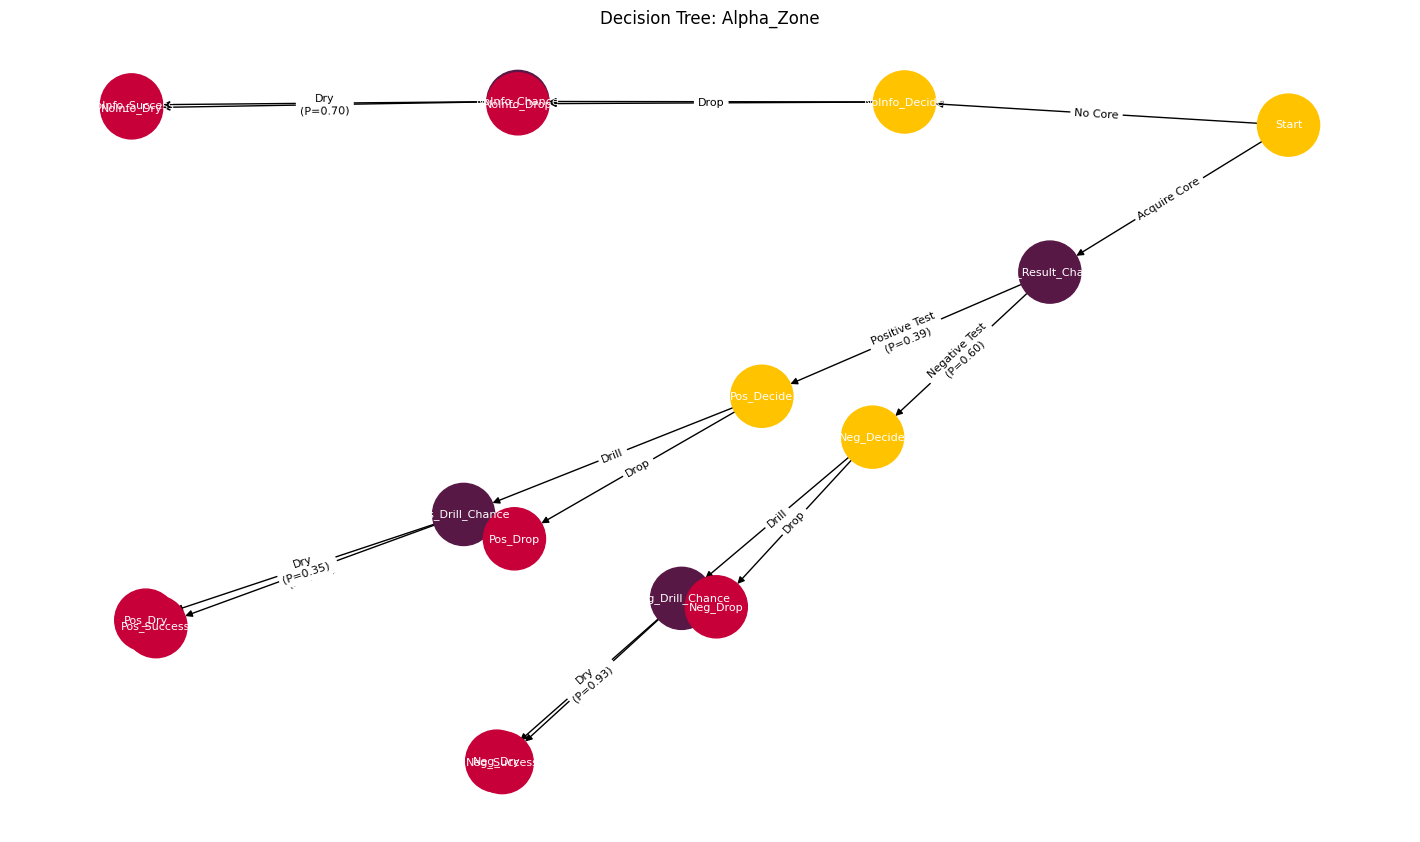

In [6]:
# Select the first prospect (Alpha_Zone)
prospect = df.iloc[0]

# Build and Solve
tree = build_decision_tree(prospect)
optimal_emv = solve_tree(tree)

# Calculate EMV of specific branches manually for reporting
# EMV without Info
emv_no_info = tree.nodes['NoInfo_Decide']['emv']
# EMV with Info (Before subtracting cost of info)
emv_with_info_gross = tree.nodes['Info_Result_Chance']['emv']
cost_info = prospect['cost_core_mmusd']
emv_with_info_net = emv_with_info_gross - cost_info

voi = emv_with_info_net - emv_no_info

print(f"--- Analysis for {prospect['prospect_id']} ---")
print(f"EMV (No Info): ${emv_no_info:.2f} MM")
print(f"EMV (With Info - Net): ${emv_with_info_net:.2f} MM")
print(f"Cost of Info: ${cost_info:.2f} MM")
print(f"Value of Information (VOI): ${voi:.2f} MM")

if voi > 0:
    print("DECISION: Acquire the Core.")
else:
    print("DECISION: Do not acquire the Core.")

# Visualization
plt.figure(figsize=(14, 8))
pos = nx.kamada_kawai_layout(tree) 

# Draw nodes
colors = []
for n in tree.nodes():
    typ = tree.nodes[n]['type']
    if typ == 'decision': colors.append('#FFC300') # Yellow
    elif typ == 'chance': colors.append('#581845') # Purple
    else: colors.append('#C70039') # Red

nx.draw(tree, pos, with_labels=True, node_color=colors, node_size=2000, font_size=8, font_color='white', arrows=True)

# Draw Edge Labels (Probabilities/Actions)
edge_labels = {}
for u, v, d in tree.edges(data=True):
    label = d.get('label', d.get('action', ''))
    if 'prob' in d and d['prob'] < 1.0:
        label += f"\n(P={d['prob']:.2f})"
    edge_labels[(u,v)] = label

nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size=8)
plt.title(f"Decision Tree: {prospect['prospect_id']}")
plt.show()